Importing Necessary Packages

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, Activation,concatenate, Attention, Bidirectional,GlobalAveragePooling1D
from keras import optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
import keras_tuner as kt
import math
from datetime import datetime, timedelta
from scipy.stats import norm

Data Pull and Plot

In [2]:
start_date = '2016-01-01'
today = datetime.now()
end_date = datetime.strftime(today, '%Y-%m-%d')
#end_date = '2024-01-08'
display(end_date)
data = yf.download("ETH-USD", start=start_date, end=end_date) #Displays till yesterday as today is not complete
data = data.reset_index()
dates = data['Date']

'2024-01-10'

[*********************100%%**********************]  1 of 1 completed


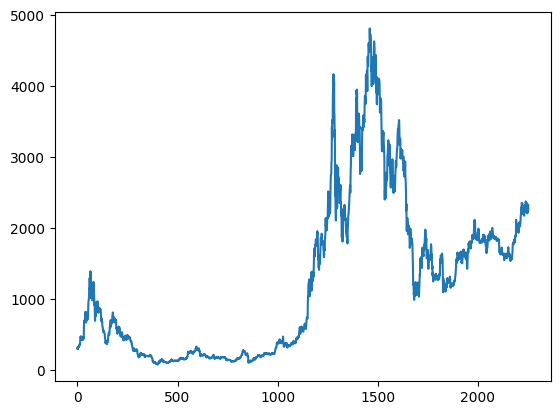

In [3]:
dataclose = data.reset_index()['Close']
plt.plot(dataclose)

In [4]:
scaler = MinMaxScaler()
dataclose = scaler.fit_transform(np.array(dataclose).reshape(-1,1))
dataclose.shape

(2253, 1)

In [5]:
train_size = int(len(dataclose)*0.6)
test_size = len(dataclose) - train_size
train_data,test_data = dataclose[0:train_size,:],dataclose[train_size:len(dataclose),:1]

In [6]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [7]:
# calling the create dataset function to split the data into 
# input output datasets with time step 100
time_step = 100
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [8]:
model = Sequential()
model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [9]:
model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 50,batch_size = 64,verbose = 1)

Epoch 1/50

20/20 [==============================] - 14s 292ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 2/50
20/20 [==============================] - 4s 185ms/step - loss: 0.0015 - val_loss: 0.0050
Epoch 3/50
20/20 [==============================] - 4s 191ms/step - loss: 0.0015 - val_loss: 0.0054
Epoch 4/50
20/20 [==============================] - 4s 194ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 5/50
20/20 [==============================] - 4s 183ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 6/50
20/20 [==============================] - 4s 199ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 7/50
20/20 [==============================] - 4s 215ms/step - loss: 0.0011 - val_loss: 0.0032
Epoch 8/50
20/20 [==============================] - 4s 223ms/step - loss: 9.2402e-04 - val_loss: 0.0024
Epoch 9/50
20/20 [==============================] - 4s 193ms/step - loss: 8.2732e-04 - val_loss: 0.0032
Epoch 10/50
20/20 [==============================] - 4s 187ms/step - loss: 7.9478e-04 - va

In [10]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

26/26 [==============================] - 1s 42ms/step


In [11]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [12]:
print(math.sqrt(mean_squared_error(Y_train,train_predict)) / Y_train.shape[0])
print(math.sqrt(mean_squared_error(Y_test,test_predict)) / Y_test.shape[0])

0.7642645548931102
2.8200855109401455


In [13]:
look_back = 100

In [14]:
trainPredictPlot = np.empty_like(dataclose)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [15]:
testPredictPlot = np.empty_like(dataclose)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(dataclose) - 1,:] = test_predict

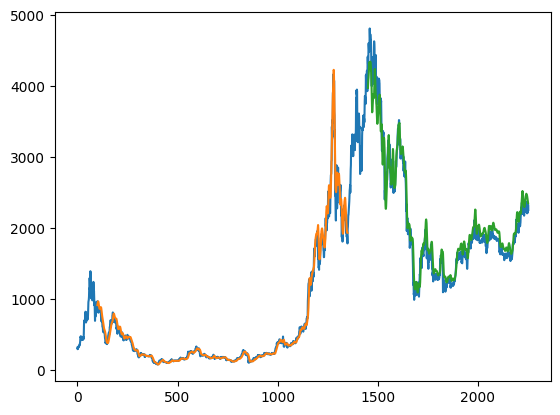

In [16]:
plt.plot(scaler.inverse_transform(dataclose))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [17]:
prediction_data = np.array(dataclose[-100:]).transpose()
prediction = scaler.inverse_transform(model.predict(prediction_data))[0][0]
print("Prediction for: ", end_date, "        CLOSE: ", prediction)

1/1 [==============================] - 0s 52ms/step
Prediction for:  2024-01-10         CLOSE:  2356.9126


In [18]:
results = []
runs = 100
for i in range(runs):
    print("RUN: ", i+1)
    model = Sequential()
    model.add(LSTM(50,return_sequences = True,input_shape = (X_train.shape[1],1)))
    model.add(LSTM(50,return_sequences = True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error',optimizer = 'adam')
    model.fit(X_train,Y_train,validation_data = (X_test,Y_test),epochs = 10,batch_size = 64,verbose = 1)
    prediction = scaler.inverse_transform(model.predict(prediction_data))[0][0]
    print("Prediction for: ", end_date, "        CLOSE: ", prediction)
    results.append(prediction)

plt.hist(results)
mu, std = norm.fit(data)
xmin, xmax = plt.xlim() 
x = np.linspace(xmin, xmax, 100) 
p = norm.pdf(x, mu, std) 
  
plt.plot(x, p, 'k', linewidth=2) 
title = "Fit Values: {:.2f} and {:.2f}".format(mu, std) 
plt.title(title)
plt.show()   

RUN:  1
Epoch 1/10
20/20 [==============================] - 11s 272ms/step - loss: 0.0078 - val_loss: 0.0085
Epoch 2/10
20/20 [==============================] - 4s 217ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 3/10
20/20 [==============================] - 4s 208ms/step - loss: 0.0013 - val_loss: 0.0022
Epoch 4/10
20/20 [==============================] - 4s 194ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 5/10
20/20 [==============================] - 4s 186ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 6/10
20/20 [==============================] - 4s 189ms/step - loss: 0.0011 - val_loss: 0.0028
Epoch 7/10
20/20 [==============================] - 4s 188ms/step - loss: 9.5997e-04 - val_loss: 0.0029
Epoch 8/10
20/20 [==============================] - 4s 199ms/step - loss: 8.7457e-04 - val_loss: 0.0040
Epoch 9/10
20/20 [==============================] - 5s 230ms/step - loss: 8.7731e-04 - val_loss: 0.0031
Epoch 10/10
1/1 [==============================] - 1s 1s/step
Prediction for:  

KeyboardInterrupt: 

In [ ]:
print(results)

[2362.327, 2329.575, 2428.258, 2254.8396, 2376.3472, 2151.7515, 2552.5286, 2336.9531, 2279.7412, 2372.0667, 2311.208, 2154.275, 2389.9006, 2354.7603, 2372.8728, 2162.437, 2392.6829, 2307.1738, 2342.3525, 2441.2314, 2253.8586, 1983.5938, 2202.264, 2074.658, 2391.7893, 1987.0538, 2215.5352, 2231.252, 2381.2888, 2426.7754, 2348.6196, 2221.9556, 2306.7668, 2373.1445, 2314.2837, 2245.6682, 2415.7803, 2083.0278, 2256.8384, 2300.8198, 2520.4556, 2361.2517, 2210.9385, 2385.8137, 2438.4175, 2224.3604, 2283.5115, 2275.365, 2057.7854, 2409.5557, 2371.8008, 2359.013, 2198.401, 2420.495, 2360.0632, 2272.6519, 2308.6487, 2182.1362, 2308.2268, 2323.2747, 2362.4048, 2235.6782, 2448.9373, 2361.3342, 2208.8208, 2156.357, 2006.9468, 2293.898, 2244.7244, 2486.2273, 2234.7722, 2053.481, 2312.6194, 2348.5562, 2289.0508, 2275.326, 2112.2703, 2260.159, 2389.2246, 2368.445, 2089.029, 2300.9282, 2415.1274, 2247.6057, 2483.7888, 2194.5002, 2230.5823, 2316.0342, 2180.0369, 2154.1064, 2288.186, 2518.5757, 2344.634

TypeError: unsupported operand type(s) for -: 'list' and 'int'